In [1]:
import torch
from VAE.vae import VAE
from loss.loss import vae_loss 
from optimisation.optimisation import run_optuna
from data_processing.dataload import load_normalize_data
import json
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

C:\Users\gabriel.legros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


6.1.2


In [2]:
# ============================================================
# Chargement des meilleurs paramètres
# ============================================================
with open("best_params.json", "r") as f:
    best_params = json.load(f)

latent_dim = best_params["latent_dim"]
hidden_dim = best_params["hidden_dim"]
lr = best_params["lr"]
dropout = best_params["dropout"]
print("Best parameters found:")
print("Latent dimension:", latent_dim)
print("Hidden dimension:", hidden_dim)
print("Learning rate:", lr)
print("Dropout rate:", dropout)

Best parameters found:
Latent dimension: 64
Hidden dimension: 512
Learning rate: 0.00015346582907785702
Dropout rate: 0.00431262498289598


In [4]:
# ============================================================
# Chargement et normalisation des données
# ============================================================
dataset, scaler_x, scaler_y = load_normalize_data(batch_size=None, return_dataset=True)  # Adapter la fonction pour retourner le dataset complet

# Split du dataset en train et test (80%/20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

dataloader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Pour affichage des shapes
data_iter = iter(dataloader_train)
X_batch, y_batch = next(data_iter)
print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)

dim_x = X_batch.shape[1]
dim_y = y_batch.shape[1]
print("dim_x:", dim_x)
print("dim_y:", dim_y)

input_dim = dim_x + dim_y

# ============================================================
# Configuration du device
# ============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

X_batch shape: torch.Size([64, 4])
y_batch shape: torch.Size([64, 5000])
dim_x: 4
dim_y: 5000
Using device: cuda


Epoch 1/300, Loss: 0.9536
Epoch 2/300, Loss: 0.9483
Epoch 3/300, Loss: 0.9505
Epoch 4/300, Loss: 0.9493
Epoch 5/300, Loss: 0.9488
Epoch 6/300, Loss: 0.9494
Epoch 7/300, Loss: 0.9487
Epoch 8/300, Loss: 0.9512
Epoch 9/300, Loss: 0.9485
Epoch 10/300, Loss: 0.9474
Epoch 11/300, Loss: 0.9487
Epoch 12/300, Loss: 0.9484
Epoch 13/300, Loss: 0.9484
Epoch 14/300, Loss: 0.9474
Epoch 15/300, Loss: 0.9497
Epoch 16/300, Loss: 0.9490
Epoch 17/300, Loss: 0.9474
Epoch 18/300, Loss: 0.9477
Epoch 19/300, Loss: 0.9488
Epoch 20/300, Loss: 0.9480
Epoch 21/300, Loss: 0.9419
Epoch 22/300, Loss: 0.9078
Epoch 23/300, Loss: 0.8847
Epoch 24/300, Loss: 0.8765
Epoch 25/300, Loss: 0.8769
Epoch 26/300, Loss: 0.8736
Epoch 27/300, Loss: 0.8711
Epoch 28/300, Loss: 0.8688
Epoch 29/300, Loss: 0.8658
Epoch 30/300, Loss: 0.8652
Epoch 31/300, Loss: 0.8650
Epoch 32/300, Loss: 0.8652
Epoch 33/300, Loss: 0.8643
Epoch 34/300, Loss: 0.8632
Epoch 35/300, Loss: 0.8600
Epoch 36/300, Loss: 0.8579
Epoch 37/300, Loss: 0.8602
Epoch 38/3

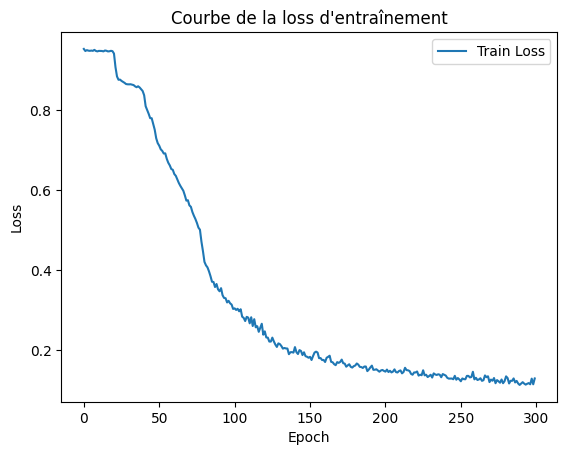

In [5]:
# ============================================================
# Initialisation du modèle et de l'optimiseur
# ============================================================
vae = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim, dropout=dropout).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
num_epochs = 300

# ============================================================
# Boucle d'entraînement
# ============================================================
train_losses = []

vae.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in dataloader_train:
        xy_batch = torch.cat([x_batch, y_batch], dim=1).to(device)

        recon, mu, log_var = vae(xy_batch)
        loss_batch = vae_loss(recon, xy_batch, mu, log_var)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

        epoch_loss += loss_batch.item()

    avg_loss = epoch_loss / len(dataloader_train)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# ============================================================
# Affichage de la courbe de loss d'entraînement
# ============================================================
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de la loss d'entraînement")
plt.legend()
plt.show()

In [6]:
# ============================================================
# Évaluation du modèle sur le jeu de test
# ============================================================
vae.eval()
eval_loss = 0
n_batches = 0

with torch.no_grad():
    for x_batch, y_batch in dataloader_test:
        xy_batch = torch.cat([x_batch, y_batch], dim=1).to(device)
        recon, mu, log_var = vae(xy_batch)
        loss = vae_loss(recon, xy_batch, mu, log_var)
        eval_loss += loss.item()
        n_batches += 1

eval_loss /= n_batches
print(f"Loss moyenne en test : {eval_loss:.4f}")

Loss moyenne en test : 0.1389


In [7]:
# ============================================================
# Sauvegarde du modèle entraîné
# ============================================================
model_path = "vae_trained.pth"
torch.save({
    'model_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim': input_dim,
    'latent_dim': latent_dim,
    'hidden_dim': hidden_dim,
    'dropout': dropout,
    'scaler_x': scaler_x,
    'scaler_y': scaler_y
}, model_path)
print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous vae_trained.pth


recon_x shape: (64, 4)
recon_y shape: (64, 5000)
X normalisé: [ 0.19528732 -0.10740453  0.071913    0.24297985]
Y normalisé: [-0.153485   -0.11020882 -0.15210885 ...  0.0806513   0.0475551
  0.08667575]
orig_x shape: (64, 4)
orig_y shape: (64, 5000)
X normalisé: [ 1.3622614  -0.83491844 -0.551395    0.8048828 ]
Y normalisé: [-0.12477919 -0.12474193 -0.12470493 ... -0.1452507  -0.14510621
 -0.10204268]


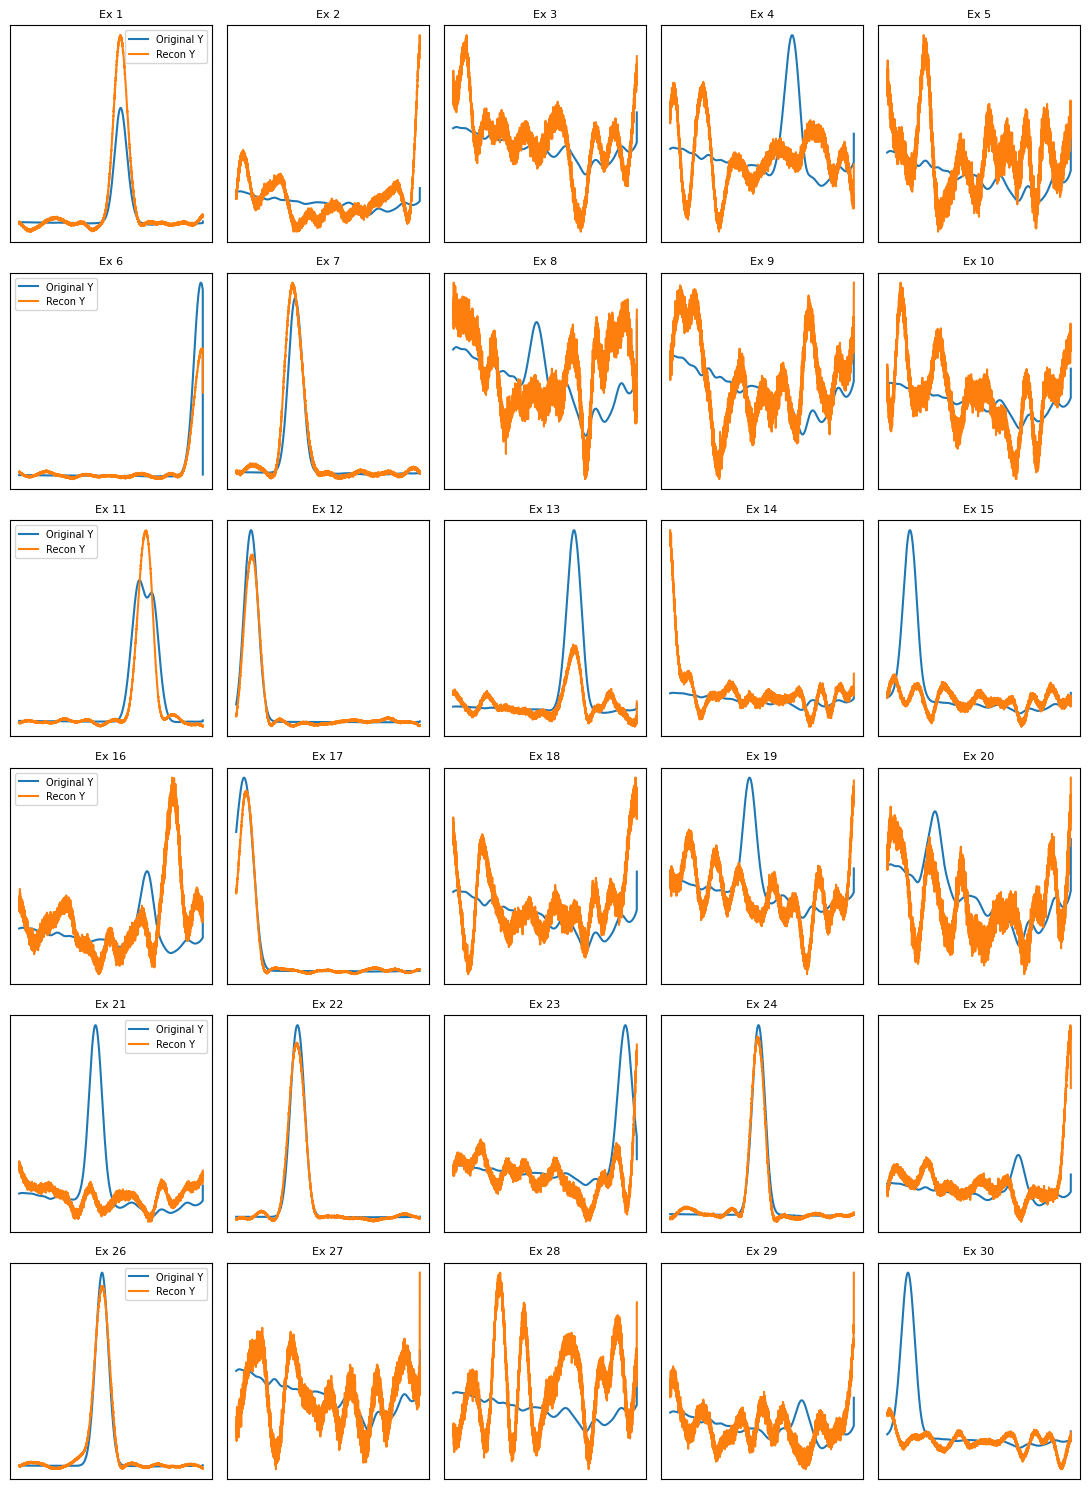

In [15]:
# ============================================================
# Prédiction et reconstruction sur un batch de test
# ============================================================

vae.eval()
with torch.no_grad():
    # Prendre un batch de test
    x_batch, y_batch = next(iter(dataloader_test))
    xy_batch = torch.cat([x_batch, y_batch], dim=1).to(device)

    # Reconstruction
    recon, mu, log_var = vae(xy_batch)

    # Convertir en numpy
    recon_np = recon.cpu().numpy()
    original_np = xy_batch.cpu().numpy()

# Séparer X et y dans la reconstruction et les données originales
recon_x = recon_np[:, :dim_x]
recon_y = recon_np[:, dim_x:]
print("recon_x shape:", recon_x.shape)
print("recon_y shape:", recon_y.shape)
print("X normalisé:", recon_x[0])
print("Y normalisé:", recon_y[0])

orig_x = original_np[:, :dim_x]
orig_y = original_np[:, dim_x:]
print("orig_x shape:", orig_x.shape)
print("orig_y shape:", orig_y.shape)
print("X normalisé:", orig_x[0])
print("Y normalisé:", orig_y[0])

n_examples = 30
n_cols = 5
n_rows = n_examples // n_cols

plt.figure(figsize=(2.2*n_cols, 2.5*n_rows))
for i in range(n_examples):
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(orig_y[i], label='Original Y')
    plt.plot(recon_y[i], label='Recon Y')
    plt.title(f"Ex {i+1}", fontsize=8)
    plt.xticks([])
    plt.yticks([])
    if i % n_cols == 0:
        plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# Affichage des reconstructions pour les 10 premiers exemples du batch de test
# ============================================================

import matplotlib.pyplot as plt

n_examples = 10
plt.figure(figsize=(20, 2.5))
for i in range(n_examples):
    plt.subplot(1, n_examples, i+1)
    plt.plot(orig_y[i], label='Original Y')
    plt.plot(recon_y[i], label='Recon Y')
    plt.title(f"Ex {i+1}")
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# Affichage des reconstructions pour les 10 premiers exemples du batch de test
# ============================================================

import matplotlib.pyplot as plt

n_examples = 10
plt.figure(figsize=(20, 2.5))
for i in range(n_examples):
    plt.subplot(1, n_examples, i+1)
    plt.plot(orig_y[i], label='Original Y')
    plt.plot(recon_y[i], label='Recon Y')
    plt.title(f"Ex {i+1}")
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# # Inverse de la standardisation
# recon_x_orig = scaler_x.inverse_transform(recon_x)
# recon_y_orig = scaler_y.inverse_transform(recon_y)

# orig_x_orig = scaler_x.inverse_transform(orig_x)
# orig_y_orig = scaler_y.inverse_transform(orig_y)

# # ============================================================
# # Affichage d'exemples (ici on affiche la première donnée du batch)
# # ============================================================
# index = 0

# print("=== Données originales ===")
# print("X:", orig_x_orig[index])
# print("Y:", orig_y_orig[index])

# print("\n=== Reconstruction ===")
# print("X reconstruit:", recon_x_orig[index])
# print("Y reconstruit:", recon_y_orig[index])

# Optionnel: tu peux aussi faire des plots si tes données sont visuelles ou graphiques
# Par exemple, si X est une image ou un vecteur 2D:
# plt.figure()
# plt.plot(orig_x_orig[index], label='Original X')
# plt.plot(recon_x_orig[index], label='Recon X')
# plt.legend()
# plt.show()